## PDFs of echo top height

In [1]:
from matplotlib import pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
from scipy import optimize, stats
from scipy.signal import argrelextrema
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from glob import glob

In [2]:
hist1_path = '/home/rjackson/data/echo_top_histograms1_hour.cdf'
hist2_path = '/home/rjackson/data/new_eth_hists/echo_top_histograms*.cdf'

height_bins = np.arange(0, 20000, 500)
hist2_list = glob(hist2_path)
for hist2_path in hist2_list:
    hist2_file = Dataset(hist2_path, mode='r')
    try:
        print(hist2_path)
        hist_break = hist_break + hist2_file.variables['hist_break'][:]
        hist_monsoon = hist_monsoon + hist2_file.variables['hist_monsoon'][:]
        #hist_total = hist_total + hist2_file.variables['hist_total'][:]
    except:
        hist_break = hist2_file.variables['hist_break'][:]
        hist_monsoon = hist2_file.variables['hist_monsoon'][:]
        #hist_total = hist2_file.variables['hist_total'][:]
    hist2_file.close()
hist_total = hist_break + hist_monsoon
hist_break = np.sum(hist_break, axis=2)
hist_monsoon = np.sum(hist_monsoon, axis=2)
hist_total = np.sum(hist_total, axis=2)

hist_break[0,:] = 0
hist_monsoon[0,:] = 0
hist_total[0,:] = 0
b_inds = argrelextrema(hist_break, np.greater)
m_inds = argrelextrema(hist_monsoon, np.greater)
print(hist_break.shape)

/home/rjackson/data/new_eth_hists/echo_top_histograms2015.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2010.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2007.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2011.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms1999.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2017.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2014.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2016.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms1998.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2002.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2001.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2012.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2006.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2003.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2009.cdf
/home/rjackson/data/new_eth_hists/echo_top_histograms2000.cdf
/home/rj

(0, 0.1)

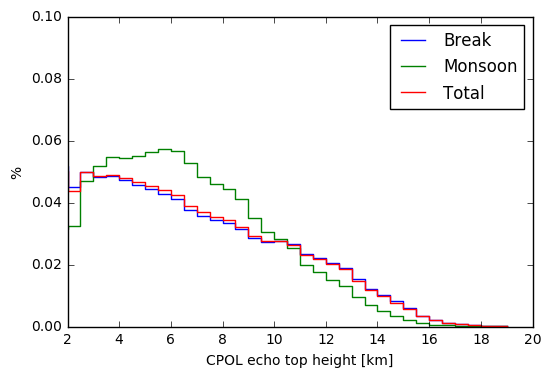

In [149]:
plt.step(height_bins[:-1]/1e3, np.sum(hist_break[:,:], axis=1)/np.sum(hist_break))
plt.step(height_bins[:-1]/1e3, np.sum(hist_monsoon[:,:], axis=1)/np.sum(hist_monsoon))
plt.step(height_bins[:-1]/1e3, np.sum(hist_total[:,:], axis=1)/np.sum(hist_total))
#plt.scatter(height_bins[b_inds[0]]/1e3, np.sum(hist_break[b_inds[0],:], axis=1)/np.sum(hist_break))
#plt.scatter(height_bins[m_inds[0]]/1e3, np.sum(hist_monsoon[m_inds[0],:], axis=1)/np.sum(hist_monsoon))
plt.legend(['Break', 'Monsoon', 'Total'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.0, 20])
plt.ylim([0, 0.10])

## Do multigaussian fits

In [3]:
def gaussian(x, center, width):
    return np.exp(-(x - center)**2/(2*width**2)) / (width*np.sqrt(2*np.pi))

def two_gaussians(x, c1, w1, c2, w2, A):
    return (A * gaussian(x, c1, w1) +
           (1 - A) * gaussian(x, c2, w2)) 

def three_gaussians(x, c1, w1, c2, w2, c3, w3, A, B):
    return (A * gaussian(x, c1, w1) +
            B * gaussian(x, c2, w2) + 
            (1 - A - B) * gaussian(x, c3, w3)) 
    
    
errfunc = lambda p, x, y: (two_gaussians(x, *p) - y)**2
errfunc3 = lambda p, x, y: (three_gaussians(x, *p) - y)**2

guess = [5, 1, 10, 1, 0.5]
guess3 = [5, 1, 10, 1, 15, 1, 0.3, 0.3]

fits_break3 = np.zeros((8, 8))
fits_monsoon3 = np.zeros((8, 8))
fits_total3 = np.zeros((8, 8))
fits_break2 = np.zeros((5, 8))
fits_monsoon2 = np.zeros((5, 8))
fits_total2 = np.zeros((5, 8))
chisquare_break3 = np.zeros(8)
chisquare_monsoon3 = np.zeros(8)
chisquare_break2 = np.zeros(8)
chisquare_monsoon2 = np.zeros(8)


for mjo_indicies in range(8):
    break_sum = np.sum(hist_break[:, mjo_indicies])/2
    monsoon_sum = np.sum(hist_monsoon[:, mjo_indicies])/2
    if(monsoon_sum == 0):
        monsoon_sum = 1
    total_sum = np.sum(hist_total[:, mjo_indicies])/2
    fits_break3[:,mjo_indicies], success = optimize.curve_fit(three_gaussians, p0=guess3[:], 
                                                              xdata=height_bins[:-1]/1e3, 
                                                              ydata=hist_break[:, mjo_indicies]/break_sum,
                                                              bounds=(0,20))
    fexp = three_gaussians(height_bins[:-1]/1e3, *fits_break3[:,mjo_indicies])
    stat, p = stats.chisquare(hist_break[:,mjo_indicies]/break_sum, fexp)
    chisquare_break3[mjo_indicies] = p
    try:
        fits_monsoon3[:,mjo_indicies], success = optimize.curve_fit(three_gaussians, p0=guess3[:], 
                                                                    xdata=height_bins[:-1]/1e3, 
                                                                    ydata=hist_monsoon[:,mjo_indicies]/monsoon_sum,
                                                                    bounds=(0,20))
        fexp = three_gaussians(height_bins[:-1]/1e3, *fits_monsoon3[:,mjo_indicies])
        stat, p = stats.chisquare(hist_monsoon[:,mjo_indicies]/monsoon_sum, fexp)
        chisquare_monsoon3[mjo_indicies] = p
    except:
        fits_monsoon3[:,mjo_indicies] = np.nan
    fits_total3[:,mjo_indicies], success = optimize.curve_fit(three_gaussians, p0=guess3[:], 
                                                              xdata=height_bins[:-1]/1e3, 
                                                              ydata=(hist_total[:,mjo_indicies])/(total_sum),
                                                              bounds=(0,20))
    fexp = three_gaussians(height_bins[:-1]/1e3, *fits_total3[:,mjo_indicies])
    stat, p = stats.chisquare(hist_total[:,mjo_indicies]/monsoon_sum, fexp)

    
    fits_break2[:,mjo_indicies], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                              xdata=height_bins[:-1]/1e3, 
                                                              ydata=hist_break[:,mjo_indicies]/break_sum,
                                                              bounds=(0,20))
    fexp = two_gaussians(height_bins[:-1]/1e3, *fits_break2[:,mjo_indicies])
    stat, p = stats.chisquare(hist_break[:,mjo_indicies]/monsoon_sum, fexp)
    chisquare_break2[mjo_indicies] = p
    fits_monsoon2[:,mjo_indicies], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                xdata=height_bins[:-1]/1e3, 
                                                                ydata=hist_monsoon[:,mjo_indicies]/monsoon_sum,
                                                                bounds=(0,20))
    fexp = two_gaussians(height_bins[:-1]/1e3, *fits_monsoon2[:,mjo_indicies])
    stat, p = stats.chisquare(hist_monsoon[:,mjo_indicies]/monsoon_sum, fexp)
    chisquare_monsoon2[mjo_indicies] = p
    fits_total2[:,mjo_indicies], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                xdata=height_bins[:-1]/1e3, 
                                                                ydata=hist_total[:,mjo_indicies]/total_sum,
                                                                bounds=(0,20))
    fexp = two_gaussians(height_bins[:-1]/1e3, *fits_total2[:,mjo_indicies])

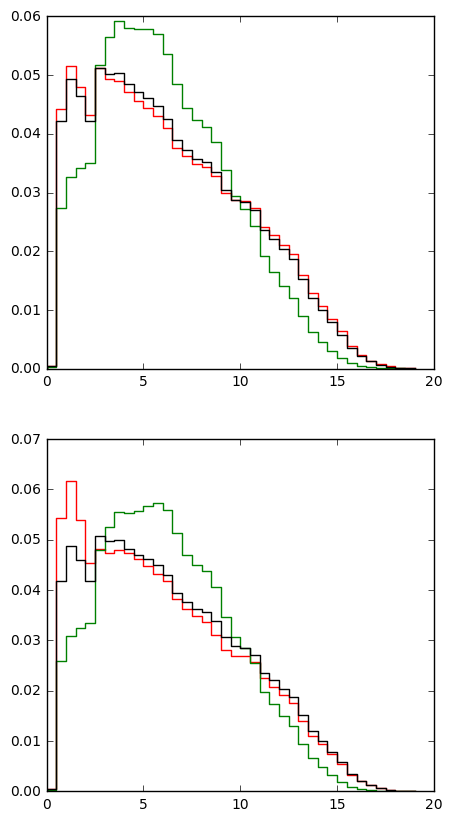

In [151]:
hist_break_mjo_aust = np.sum(hist_break[:, 3:7], axis=1)
hist_monsoon_mjo_aust = np.sum(hist_monsoon[:, 3:7], axis=1)
hist_total_mjo_aust = np.sum(hist_total[:, 3:7], axis=1)
hist_break_mjo_noaust = np.sum(hist_break[:, 1:3], axis=1) + hist_break[:,7]
hist_monsoon_mjo_noaust = np.sum(hist_monsoon[:, 3:7], axis=1) + hist_monsoon[:,7]
hist_total_mjo_noaust = np.sum(hist_total[:, 3:7], axis=1) + hist_monsoon[:,7]

plt.figure(figsize=(5,10))
plt.subplot(211)
plt.step(height_bins[:-1]/1e3, hist_break_mjo_aust/np.sum(hist_break_mjo_aust), color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon_mjo_aust/np.sum(hist_monsoon_mjo_aust), color='g')
plt.step(height_bins[:-1]/1e3, hist_total_mjo_aust/np.sum(hist_total_mjo_aust), color='k')

plt.subplot(212)
plt.step(height_bins[:-1]/1e3, hist_break_mjo_noaust/np.sum(hist_break_mjo_noaust), color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon_mjo_noaust/np.sum(hist_monsoon_mjo_noaust), color='g')
plt.step(height_bins[:-1]/1e3, hist_total_mjo_noaust/np.sum(hist_total_mjo_noaust), color='k')

In [152]:
plt.figure(figsize=(6,6))
print(chisquare_break3)
print(chisquare_monsoon3)
print(chisquare_break2)
print(chisquare_monsoon2)

[1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 0. 1.]
[1.38513135e-135 8.45242749e-129 0.00000000e+000 0.00000000e+000
 9.94972735e-001 1.96085424e-010 5.15184168e-009 3.36859535e-050]
[1. 1. 1. 1. 1. 1. 1. 1.]


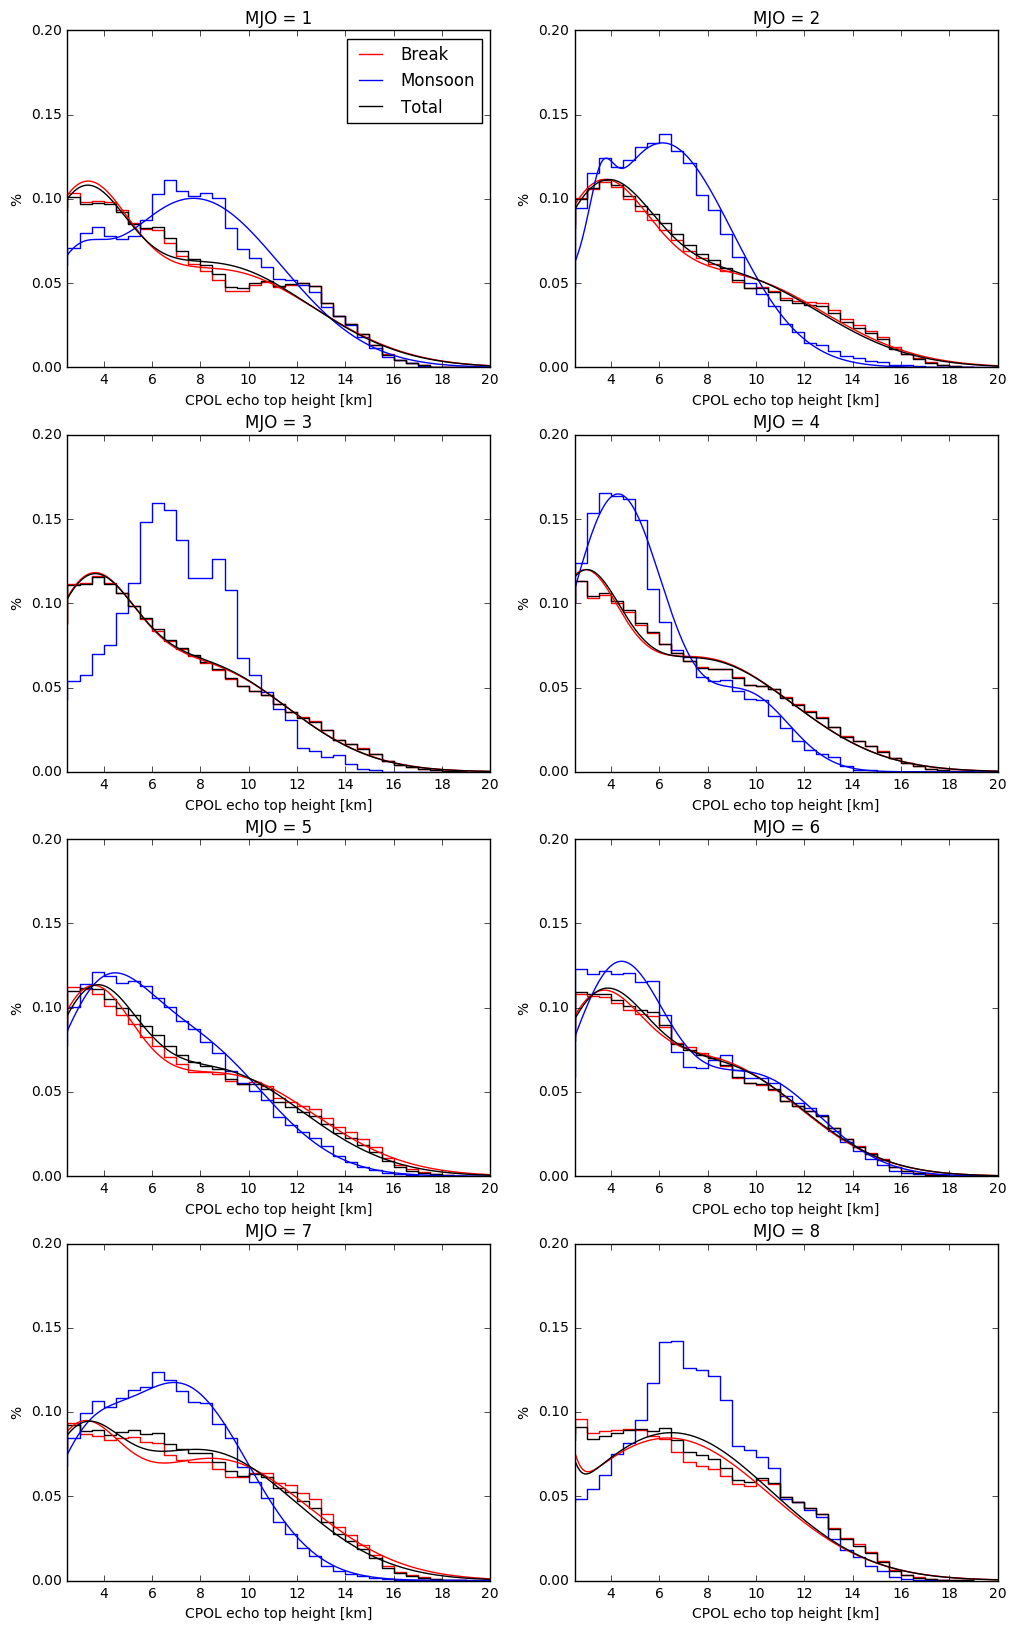

In [12]:
x_curve = np.arange(0, 20, 0.01)
plt.figure(figsize=(12,20))
plt.subplot(421)
plt.step(height_bins[:-1]/1e3, hist_break[:,0]/np.sum(hist_break[:,0])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,0]/np.sum(hist_monsoon[:,0])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,0]/np.sum(hist_total[:,0])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,0]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,0]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,0]), color='k')
plt.legend(['Break', 'Monsoon', 'Total'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.5,20])
plt.ylim([0, 0.2])
plt.title('MJO = 1')
plt.subplot(422)
plt.step(height_bins[:-1]/1e3, hist_break[:,1]/np.sum(hist_break[:,1])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,1]/np.sum(hist_monsoon[:,1])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,1]/np.sum(hist_total[:,1])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,1]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,1]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,1]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.5,20])
plt.ylim([0, 0.2])
plt.title('MJO = 2')
plt.subplot(423)
plt.step(height_bins[:-1]/1e3, hist_break[:,2]/np.sum(hist_break[:,2])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,2]/np.sum(hist_monsoon[:,2])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,2]/np.sum(hist_total[:,2])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,2]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,2]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,2]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.5,20])
plt.ylim([0, 0.2])
plt.title('MJO = 3')
plt.subplot(424)
plt.step(height_bins[:-1]/1e3, hist_break[:,3]/np.sum(hist_break[:,3])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,3]/np.sum(hist_monsoon[:,3])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,3]/np.sum(hist_total[:,3])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,3]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,3]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,3]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.5,20])
plt.ylim([0, 0.2])
plt.title('MJO = 4')
plt.subplot(425)
plt.step(height_bins[:-1]/1e3, hist_break[:,4]/np.sum(hist_break[:,4])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,4]/np.sum(hist_monsoon[:,4])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,4]/np.sum(hist_total[:,4])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,4]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,4]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,4]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.5,20])
plt.ylim([0, 0.2])
plt.title('MJO = 5')
plt.subplot(426)
plt.step(height_bins[:-1]/1e3, hist_break[:,5]/np.sum(hist_break[:,5])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,5]/np.sum(hist_monsoon[:,5])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,5]/np.sum(hist_total[:,5])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,5]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,5]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,5]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.5,20])
plt.ylim([0, 0.2])
plt.title('MJO = 6')
plt.subplot(427)
plt.step(height_bins[:-1]/1e3, hist_break[:,6]/np.sum(hist_break[:,6])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,6]/np.sum(hist_monsoon[:,6])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,6]/np.sum(hist_total[:,6])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,6]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,6]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,6]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.5,20])
plt.ylim([0, 0.2])
plt.title('MJO = 7')
plt.subplot(428)
plt.step(height_bins[:-1]/1e3, hist_break[:,7]/np.sum(hist_break[:,7])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,7]/np.sum(hist_monsoon[:,7])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,7]/np.sum(hist_total[:,7])*2, color='k')
plt.plot(x_curve, two_gaussians(x_curve, *fits_break2[:,7]), color='r')
plt.plot(x_curve, two_gaussians(x_curve, *fits_monsoon2[:,7]), color='b')
plt.plot(x_curve, two_gaussians(x_curve, *fits_total2[:,7]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.xlim([2.5,20])
plt.ylim([0, 0.2])
plt.title('MJO = 8')

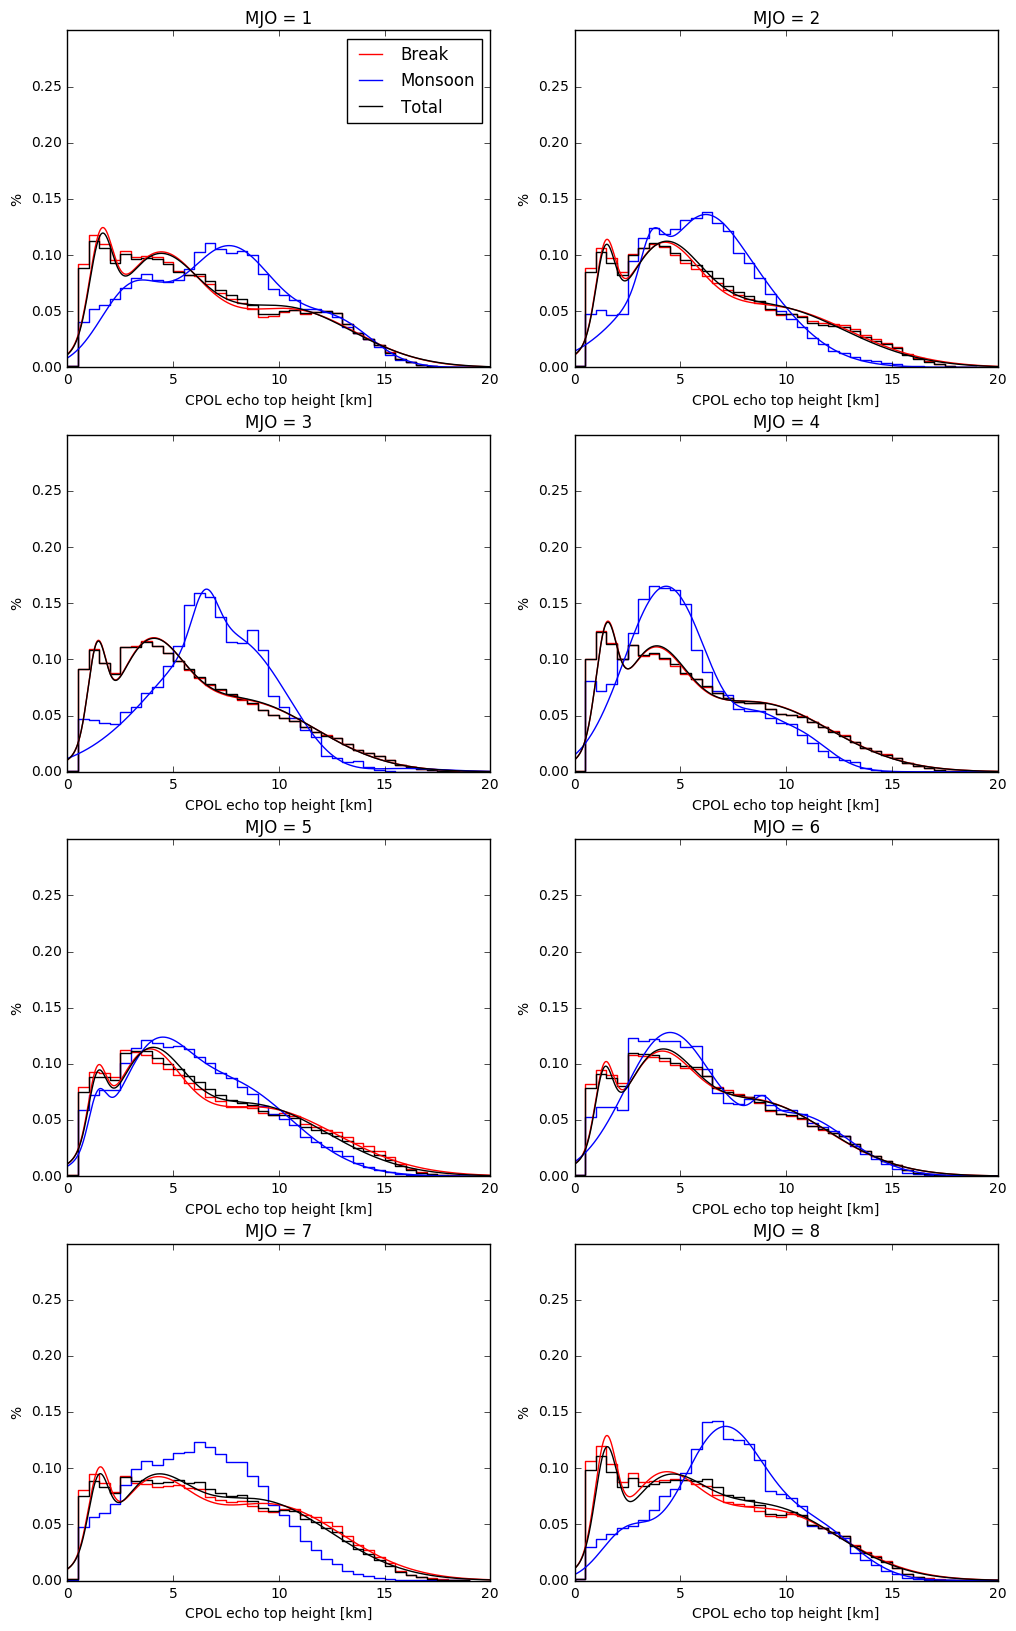

In [222]:
x_curve = np.arange(0, 20, 0.01)
plt.figure(figsize=(12,20))
plt.subplot(421)
plt.step(height_bins[:-1]/1e3, hist_break[:,0]/np.sum(hist_break[:,0])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,0]/np.sum(hist_monsoon[:,0])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,0]/np.sum(hist_total[:,0])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,0]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,0]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,0]), color='k')
plt.legend(['Break', 'Monsoon', 'Total'])
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 1')
plt.subplot(422)
plt.step(height_bins[:-1]/1e3, hist_break[:,1]/np.sum(hist_break[:,1])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,1]/np.sum(hist_monsoon[:,1])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,1]/np.sum(hist_total[:,1])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,1]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,1]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,1]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 2')
plt.subplot(423)
plt.step(height_bins[:-1]/1e3, hist_break[:,2]/np.sum(hist_break[:,2])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,2]/np.sum(hist_monsoon[:,2])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,2]/np.sum(hist_total[:,2])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,2]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,2]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,2]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 3')
plt.subplot(424)
plt.step(height_bins[:-1]/1e3, hist_break[:,3]/np.sum(hist_break[:,3])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,3]/np.sum(hist_monsoon[:,3])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,3]/np.sum(hist_total[:,3])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,3]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,3]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,3]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 4')
plt.subplot(425)
plt.step(height_bins[:-1]/1e3, hist_break[:,4]/np.sum(hist_break[:,4])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,4]/np.sum(hist_monsoon[:,4])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,4]/np.sum(hist_total[:,4])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,4]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,4]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,4]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 5')
plt.subplot(426)
plt.step(height_bins[:-1]/1e3, hist_break[:,5]/np.sum(hist_break[:,5])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,5]/np.sum(hist_monsoon[:,5])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,5]/np.sum(hist_total[:,5])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,5]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,5]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,5]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 6')
plt.subplot(427)
plt.step(height_bins[:-1]/1e3, hist_break[:,6]/np.sum(hist_break[:,6])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,6]/np.sum(hist_monsoon[:,6])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,6]/np.sum(hist_total[:,6])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,6]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,6]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,6]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 7')
plt.subplot(428)
plt.step(height_bins[:-1]/1e3, hist_break[:,7]/np.sum(hist_break[:,7])*2, color='r')
plt.step(height_bins[:-1]/1e3, hist_monsoon[:,7]/np.sum(hist_monsoon[:,7])*2, color='b')
plt.step(height_bins[:-1]/1e3, hist_total[:,7]/np.sum(hist_total[:,7])*2, color='k')
plt.plot(x_curve, three_gaussians(x_curve, *fits_break3[:,7]), color='r')
plt.plot(x_curve, three_gaussians(x_curve, *fits_monsoon3[:,7]), color='b')
plt.plot(x_curve, three_gaussians(x_curve, *fits_total3[:,7]), color='k')
plt.xlabel('CPOL echo top height [km]')
plt.ylabel('%')
plt.ylim([0, 0.3])
plt.title('MJO = 8')

In [6]:
from scipy import interpolate
def calc_percentile_from_hist(hist, bins, percent):
    cdf = np.cumsum(hist)/np.sum(hist)*100
    cdf_func = interpolate.interp1d(cdf, bins)
    return cdf_func(percent)

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


[[3.03125088 3.38647136 3.22111064 2.66495414 3.27217822 3.2177638
  2.82980352 1.60922922]
 [1.91192572 2.07360495 1.91013713 1.54985546 1.83557757 1.87677754
  1.70450087 0.54417301]
 [8.80941509 8.83314185 7.97515863 7.61295642 8.87947863 8.05886275
  8.54871918 6.35340485]
 [3.94762698 3.94495096 3.62721857 3.85757237 3.8263615  3.64386083
  3.91563671 4.21329322]
 [0.43009519 0.46487482 0.42912185 0.3455328  0.42040603 0.37379194
  0.29073884 0.10662144]]
2.9961749203831873
3.804190723322399
8.275004243273633
8.525828209620354
2.8120155234456186
5.313450879859603
7.992780104954399
8.044671521604592
[[ 1.57561852  1.44359211  1.3850515   1.47581232  1.39007122  1.39025851
   1.46678992  1.45402373]
 [ 0.53779334  0.45074594  0.41906096  0.47774942  0.4176318   0.42108947
   0.47781121  0.49042698]
 [ 4.22029357  3.97814203  3.76412738  3.57870141  3.64938637  3.73823616
   3.84955435  3.91707234]
 [ 2.01179176  1.78602435  1.62483831  1.55758386  1.61239764  1.67583679
   1.8321064

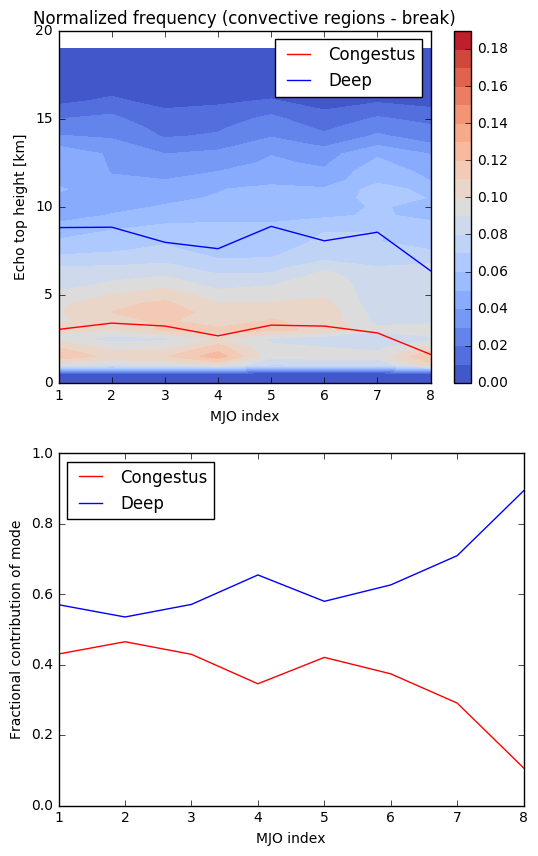

In [7]:
hist_mjo = hist_break
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
# Calculate percentiles
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_mjo[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)   
plt.contourf(mjos_2d, bins_2d, hist_mjo/np.sum(hist_mjo, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.2,0.01))
print(fits_break2)
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
plt.plot(np.arange(1,9), fits_break2[0,:][fits_break2[4,:] < 0.95], color = 'r', linestyle='-', label="Congestus")
plt.plot(np.arange(1,9), fits_break2[2,:][fits_break2[4,:] > 0.05], color = 'b', linestyle='-', label="Deep")
#plt.plot(np.arange(1,9), fits_break3[4,:], color = 'g', linestyle='-', label="Overshooting")
plt.legend()
plt.ylim([0,20])
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km]')
plt.title('Normalized frequency (convective regions - break)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_break2[4,:], label="Congestus", color='r')
plt.plot(np.arange(1,9), 1-fits_break2[4,:], label="Deep", color='b')
#plt.plot(np.arange(1,9), 1-np.sum(fits_break3[6:8,:], axis=0), label="Overshooting", color= 'g')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')
print(fits_break2[0,3:7].mean())
print(fits_monsoon2[0,3:7].mean())
print(fits_break2[2,3:7].mean())
print(fits_monsoon2[2,3:7].mean())
print(fits_break2[0,[0,1,2,7]].mean())
print(fits_monsoon2[0,[0,1,2,7]].mean())
print(fits_break2[2,[0,1,2,7]].mean())
print(fits_monsoon2[2,[0,1,2,7]].mean())
print(fits_break3)

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6449: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


(1, 8)

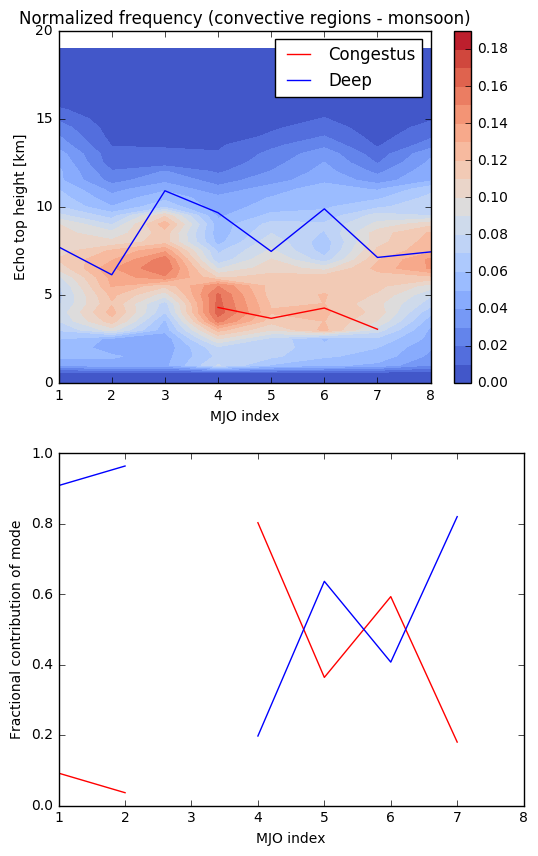

In [11]:
hist_mjo = hist_monsoon
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.contourf(mjos_2d, bins_2d, hist_monsoon/np.sum(hist_monsoon, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.2,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
#plt.plot(np.arange(1,9), fifty, color = 'k', linestyle='-')
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')
fits_monsoon2[0,[2,7]] = np.nan
fits_monsoon2[4,[2,7]] = np.nan
#mu1 = np.ma.masked_where(fits_monsoon2[4,:] < 0.05, fits_monsoon2[0,:])
#mu2 = np.ma.masked_where(1-fits_monsoon2[4,:] < 0.05, fits_monsoon2[2,:])
plt.plot(np.arange(1,9), mu1, color='r', linestyle='-', label="Congestus")
plt.plot(np.arange(1,9), mu2, color='b', linestyle='-', label="Deep")
#plt.plot(np.arange(1,9), fits_monsoon3[4,:], color='b', linestyle='-', label="Overshooting")
plt.legend(loc='best')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km]')
plt.ylim([0,20])
plt.title('Normalized frequency (convective regions - monsoon)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_monsoon2[4,:], label="Congestus", color='r')
plt.plot(np.arange(1,9), 1-fits_monsoon2[4,:], label="Deep", color='b')
#plt.plot(np.arange(1,9), 1-np.sum(fits_monsoon3[6:8,:], axis=0), label="Overshooting", color='b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.xlim([1, 8])

In [21]:
hist_mjo = hist_monsoon+hist_break
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_monsoon[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.contourf(mjos_2d, bins_2d, hist_total/np.sum(hist_total, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.2,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
#plt.plot(np.arange(1,9), fifty, color = 'k', linestyle='-')
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')

plt.plot(np.arange(1,9), fits_total2[0,:], color='b', linestyle='-', label="Mode 1")
plt.plot(np.arange(1,9), fits_total2[2,:], color='g', linestyle='-', label="Mode 2")
#plt.plot(np.arange(1,9), fits_monsoon3[4,:], color='b', linestyle='-', label="3")
plt.legend(loc='best')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km] (break)')
plt.ylim([0,20])
plt.title('Normalized frequency (convective regions - total)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_total2[4,:], label="Mode 1", color='b')
plt.plot(np.arange(1,9), 1-fits_total2[4,:], label="Mode 2", color='g')
#plt.plot(np.arange(1,9), 1-np.sum(fits_monsoon3[6:8,:], axis=0), label="Deep", color='b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')

ValueError: x and y arrays must be equal in length along interpolation axis.

In [ ]:
hist_mjo = hist_total
mjos_2d, bins_2d = np.meshgrid(np.arange(1,9), height_bins[:-1]/1e3)
five = np.zeros(8)
fifty = np.zeros(8)
ninety_five = np.zeros(8)
for mjo_index in range(0,8):
    five[mjo_index] = calc_percentile_from_hist(hist_total[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty[mjo_index] = calc_percentile_from_hist(hist_total[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five[mjo_index] = calc_percentile_from_hist(hist_total[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
plt.figure(figsize=(6,10))
plt.subplot(211)
plt.contourf(mjos_2d, bins_2d, hist_total/np.sum(hist_total, axis=0)*2,
             cmap='coolwarm', levels=np.arange(0,0.15,0.01))
#plt.plot(np.arange(1,9), five, color = 'k', linestyle='--')
#plt.plot(np.arange(1,9), fifty, color = 'k', linestyle='-')
#plt.plot(np.arange(1,9), ninety_five, color = 'k', linestyle='--')

plt.plot(np.arange(1,9), fits_total3[0,:], color='r', linestyle='-', label="1")
plt.plot(np.arange(1,9), fits_total3[2,:], color='g', linestyle='-', label="2")
plt.plot(np.arange(1,9), fits_total3[4,:], color='b', linestyle='-', label="3")
plt.legend(loc='best')
plt.xlabel('MJO index')
plt.ylabel('Echo top height [km] (break)')
plt.ylim([0,20])
plt.title('Normalized frequency (convective regions - total)')
ax = plt.colorbar()
plt.subplot(212)
plt.plot(np.arange(1,9), fits_total3[6,:], label="Shallow", color='r')
plt.plot(np.arange(1,9), fits_total3[7,:], label="Moderate", color='g')
plt.plot(np.arange(1,9), 1-np.sum(fits_total3[6:8,:], axis=0), label="Deep", color='b')
plt.xlabel('MJO index')
plt.ylabel('Fractional contribution of mode')
plt.ylim([0, 1])
plt.legend(loc='best')
print(fits_total3[6,:])

In [179]:
height_bins = np.arange(0, 20000, 500)

del hist_break, hist_monsoon
for hist2_path in hist2_list:
    hist2_file = Dataset(hist2_path, mode='r')
    try:
        hist_break = hist_break + hist2_file.variables['hist_break'][:]
        hist_monsoon = hist_monsoon + hist2_file.variables['hist_monsoon'][:]
        #hist_total = hist_total + hist2_file.variables['hist_total'][:]
    except NameError:
        hist_break = hist2_file.variables['hist_break'][:]
        hist_monsoon = hist2_file.variables['hist_monsoon'][:]
        #hist_total = hist2_file.variables['hist_total'][:]
    hist2_file.close()

print(hist_break.shape)
#Shift all to local time
hist_break = np.roll(hist_break, -9, axis=2)
hist_monsoon = np.roll(hist_monsoon, -9, axis=2)
hist_total = hist_break + hist_monsoon
hist_break[0,:] = 0
hist_monsoon[0,:] = 0
hist_total[0,:] = 0
hours = np.arange(0, 24, 1)

hist_break_mjoinactive = np.sum(hist_break[:,[0,1,2,7], :], axis=1)
hist_monsoon_mjoinactive = np.sum(hist_monsoon[:,[0,1,2,7], :], axis=1)
hist_total_mjoinactive = np.sum(hist_total[:,[0,1,2,7], :], axis=1)

hist_break_mjoactive = np.sum(hist_break[:,3:7, :], axis=1)
hist_monsoon_mjoactive = np.sum(hist_monsoon[:,3:7, :], axis=1)
hist_total_mjoactive = np.sum(hist_total[:,3:7, :], axis=1)
hour_resolution = 2
hist_break_mjoinactiven = np.zeros((39,24//hour_resolution))
hist_monsoon_mjoinactiven = np.zeros((39,24//hour_resolution))
hist_total_mjoinactiven = np.zeros((39,24//hour_resolution))

hist_break_mjoactiven = np.zeros((39,24//hour_resolution))
hist_monsoon_mjoactiven = np.zeros((39,24//hour_resolution))
hist_total_mjoactiven = np.zeros((39,24//hour_resolution))

hist_break_mjoinactivenalt = np.sum(hist_break[:,[0,1,2,7], :], axis=1)
hist_monsoon_mjoinactivenalt = np.sum(hist_monsoon[:,[0,1,2,7], :], axis=1)
hist_total_mjoinactivenalt = np.sum(hist_total[:,[0,1,2,7], :], axis=1)

hist_break_mjoactivenalt = np.sum(hist_break[:,3:7, :], axis=1)
hist_monsoon_mjoactivenalt = np.sum(hist_monsoon[:,3:7, :], axis=1)
hist_total_mjoactivenalt = np.sum(hist_total[:,3:7, :], axis=1)


fits_mjoactive2 = np.zeros((5,24//hour_resolution))
fits_mjoinactive2 = np.zeros((5,24//hour_resolution))
fits_mjoactive2u = np.zeros((2,24//hour_resolution))
fits_mjoinactive2u = np.zeros((2,24//hour_resolution))
fits_mjoactive2b = np.zeros((5,24//hour_resolution))
fits_mjoinactive2b = np.zeros((5,24//hour_resolution))
fits_mjoactive2m = np.zeros((5,24//hour_resolution))
fits_mjoinactive2m = np.zeros((5,24//hour_resolution))

guess = [3, 1, 15, 1, 0.5]
guess_u = [10, 1]
for i in range(24//hour_resolution):
    hist_reducedmjo = np.sum(hist_monsoon_mjoactive[:, hour_resolution*i:hour_resolution*(i+1)], axis=1)
    print(range(hour_resolution*i,hour_resolution*(i+1)))
    hist_reduced = np.sum(hist_monsoon_mjoinactive[:, hour_resolution*i:hour_resolution*(i+1)], axis=1)
    hist_total_mjoactiven[:,i] = hist_reducedmjo[:]/np.sum(hist_reducedmjo[:])*2
    hist_total_mjoinactiven[:,i] = hist_reduced[:]/np.sum(hist_reduced[:])*2
    if(np.sum(hist_reduced[:]) == 0):
        hist_total_mjoinactiven[:,i] = 0
    if(np.sum(hist_reducedmjo[:]) == 0):
        hist_total_mjoactiven[:,i] = 0
    fits_mjoactive2[:,i], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                  xdata=height_bins[:-1]/1e3, 
                                                                  ydata=hist_total_mjoactiven[:,i],
                                                                  bounds=(0,15))
    fits_mjoinactive2[:,i], success = optimize.curve_fit(two_gaussians, p0=guess[:], 
                                                                    xdata=height_bins[:-1]/1e3, 
                                                                    ydata=hist_total_mjoinactiven[:,i],
                                                                    bounds=(0,15))
    fits_mjoactive2u[:,i], success = optimize.curve_fit(gaussian, p0=guess_u[:], 
                                                                  xdata=height_bins[:-1]/1e3, 
                                                                  ydata=hist_total_mjoactiven[:,i],
                                                                  bounds=(0,15))
    fits_mjoinactive2u[:,i], success = optimize.curve_fit(gaussian, p0=guess_u[:], 
                                                                    xdata=height_bins[:-1]/1e3, 
                                                                    ydata=hist_total_mjoinactiven[:,i],
                                                                    bounds=(0,15))
sunrise = 6
sunset = 19.5

night_indicies = np.where(np.logical_and(hours >= sunset, hours < sunrise))
day_indicies = np.where(np.logical_or(hours <= sunset, hours >= sunrise))

hist_mjoactive2_night = np.sum(hist_break_mjoactive[:,night_indicies[0]], axis=1)
hist_mjoactive2_night = hist_mjoactive2_night/np.sum(hist_mjoactive2_night)
hist_mjoactive2_day = np.sum(hist_break_mjoactive[:,day_indicies[0]], axis=1)
hist_mjoactive2_day = hist_mjoactive2_day/np.sum(hist_mjoactive2_day)
hist_mjoinactive2_night = np.sum(hist_break_mjoinactive[:,night_indicies[0]], axis=1)
hist_mjoinactive2_night = hist_mjoinactive2_night/np.sum(hist_mjoinactive2_night)
hist_mjoinactive2_day = np.sum(hist_break_mjoinactive[:,day_indicies[0]], axis=1)
hist_mjoinactive2_day = hist_mjoinactive2_day/np.sum(hist_mjoinactive2_day)

(39, 8, 24)
range(0, 2)
range(2, 4)
range(4, 6)
range(6, 8)
range(8, 10)
range(10, 12)
range(12, 14)
range(14, 16)
range(16, 18)
range(18, 20)
range(20, 22)
range(22, 24)


/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:95: RuntimeWarning: invalid value encountered in true_divide
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:99: RuntimeWarning: invalid value encountered in true_divide


(39,)


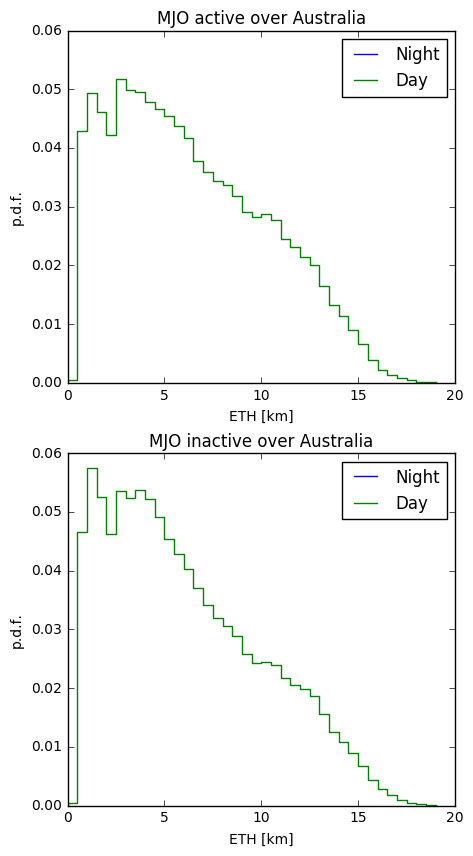

In [173]:
print(hist_mjoactive2_night.shape)
plt.figure(figsize=(5,10))
plt.subplot(211)
plt.step(height_bins[:-1]/1e3, hist_mjoactive2_night)
plt.step(height_bins[:-1]/1e3, hist_mjoactive2_day)
plt.legend(['Night', 'Day'])
plt.xlabel('ETH [km]')
plt.ylabel('p.d.f.')
plt.title('MJO active over Australia')

plt.subplot(212)
plt.step(height_bins[:-1]/1e3, hist_mjoinactive2_night)
plt.step(height_bins[:-1]/1e3, hist_mjoinactive2_day)
plt.legend(['Night', 'Day'])
plt.xlabel('ETH [km]')
plt.ylabel('p.d.f.')
plt.title('MJO inactive over Australia')

[0.39307553 0.3081832  0.49282504 0.44699954 0.36879741 0.36144999
 0.37898633 0.43128595 0.39621749 0.44059096 0.48103493 0.47413536]


/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6442: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


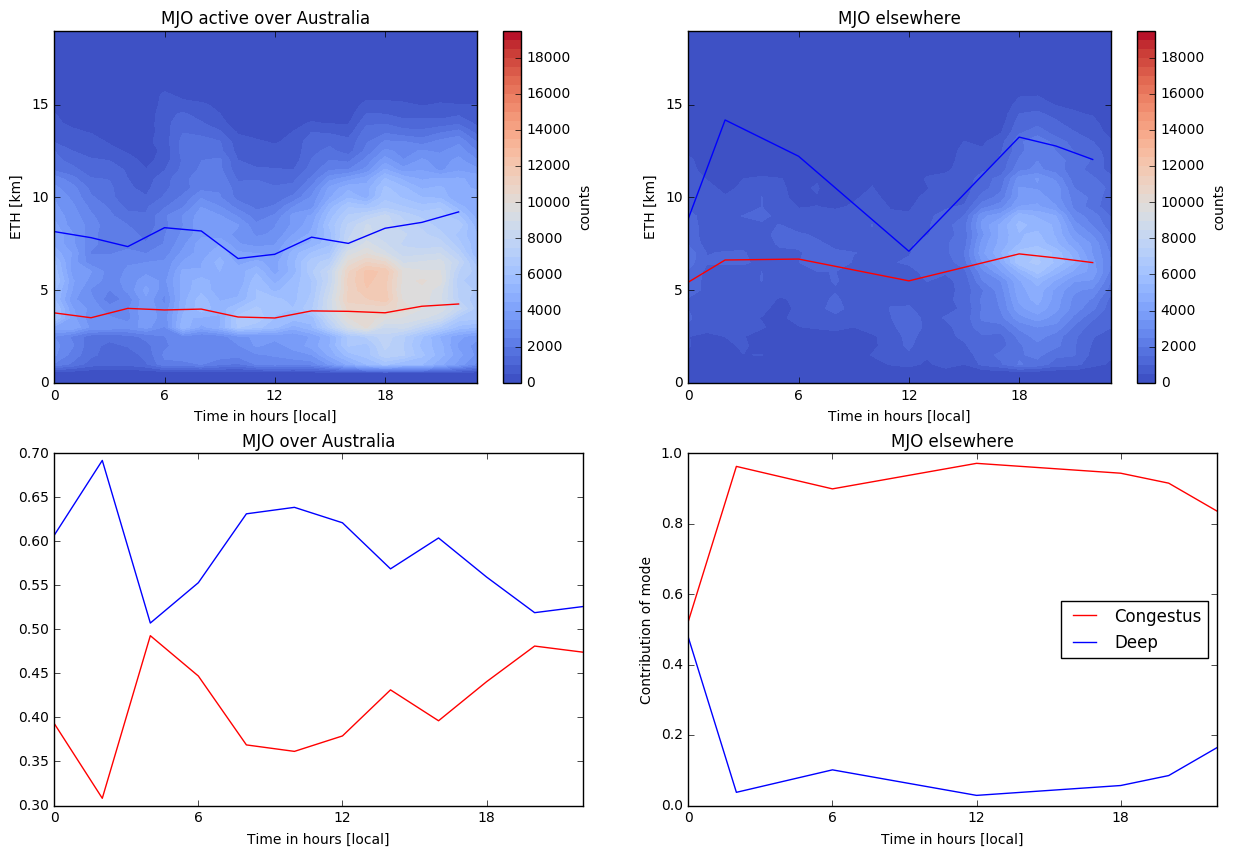

In [196]:
contribution_mjoactive = fits_mjoactive2[4,:]
contribution_mjoactive = np.ma.masked_where(np.logical_or(contribution_mjoactive > 1,
                                                          contribution_mjoactive < 0), contribution_mjoactive)
contribution_mjoinactive = fits_mjoinactive2[4,:]
contribution_mjoinactive = np.ma.masked_where(np.logical_or(contribution_mjoinactive > 1,
                                                           contribution_mjoinactive < 0), contribution_mjoinactive)
x = np.arange(0,24,hour_resolution) 
print(contribution_mjoactive)
time_order_array = np.concatenate([np.arange(9, 23, 1), np.arange(1,9,1)])
plt.figure(figsize=(15,10))
ax = plt.subplot(221)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_monsoon_mjoactive, cmap='coolwarm', levels=np.arange(0,2e4, 500))
plt.plot(x[contribution_mjoactive > 0], fits_mjoactive2[0, contribution_mjoactive > 0], color = 'r', linestyle='-', label="Mode 1")
plt.plot(x[contribution_mjoactive > 0], fits_mjoactive2[2, contribution_mjoactive > 0], color = 'b', linestyle='-', label="Mode 2")
#my_plot = ax.fill_between([sunset,sunrise], 0, 20, interpolate=True, alpha=.3)
plt.setp(my_plot, facecolor='#614126')
plt.colorbar(label='counts')
plt.title('MJO active over Australia')
plt.xticks(range(0,24,6))
plt.xlabel('Time in hours [local]')
plt.ylabel('ETH [km]')

ax = plt.subplot(222)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_monsoon_mjoinactive, cmap='coolwarm', levels=np.arange(0,2e4, 500))
plt.plot(x[~contribution_mjoinactive.mask], fits_mjoinactive2[0, ~contribution_mjoinactive.mask], color = 'r', linestyle='-', label="Mode 1")
plt.plot(x[~contribution_mjoinactive.mask], fits_mjoinactive2[2, ~contribution_mjoinactive.mask], color = 'b', linestyle='-', label="Mode 2")
#my_plot = ax.fill_between([sunset,sunrise], 0, 20, interpolate=True, alpha=.3)
plt.setp(my_plot, facecolor='#614126')
plt.xticks(range(0,24,6))
plt.colorbar(label='counts')
plt.title('MJO elsewhere')
plt.xlabel('Time in hours [local]')
plt.ylabel('ETH [km]')

ax = plt.subplot(223)
plt.plot(x[contribution_mjoactive > 0], contribution_mjoactive[contribution_mjoactive > 0], label="Mode 2", color='r')
plt.plot(x[contribution_mjoactive > 0], 1-contribution_mjoactive[contribution_mjoactive > 0], label="Mode 1", color='b')
#my_plot = ax.fill_between([sunset,sunrise], 0, 1, interpolate=True, alpha=.3)
plt.setp(my_plot, facecolor='#614126')
plt.xticks(range(0,24,6))
plt.xlabel('Time in hours [local]')
plt.xlim([0,22])
plt.title('MJO over Australia')


ax = plt.subplot(224)
plt.plot(x[~contribution_mjoinactive.mask], contribution_mjoinactive[~contribution_mjoinactive.mask], label="Mode 2", color='r')
plt.plot(x[~contribution_mjoinactive.mask], 1-contribution_mjoinactive[~contribution_mjoinactive.mask], label="Mode 1", color='b')
#my_plot = ax.fill_between([sunset,sunrise], 0, 1, interpolate=True, alpha=.3)
plt.setp(my_plot, facecolor='#614126')
plt.xticks(range(0,24,6))
plt.xlabel('Time in hours [local]')
plt.xlim([0,22])
plt.ylabel('Contribution of mode')
plt.legend(['Congestus', 'Deep'], loc='best')
plt.title('MJO elsewhere')

[[ 3.41404108  3.20826564  3.1811363   3.27171792  3.59468167  3.33163818
   2.35173453  3.34250086  2.37943659  2.45099897  2.79941237  3.22442628]
 [ 1.8478124   1.72380136  1.89327302  1.99024447  2.13501779  2.10361181
   1.23565904  2.18187014  1.23338189  1.35069177  1.66786342  1.96272375]
 [ 8.310071    7.66513082  8.08916968  8.28060732  9.06203813  8.50084767
   7.29822066 10.08602422  7.85019826  8.40680664  8.99450056  9.37085751]
 [ 3.5911855   3.68457631  3.74287207  3.61724476  3.35151087  3.6996871
   4.2475007   3.4912479   4.05314826  3.8973265   3.71764817  3.53472866]
 [ 0.40324716  0.33485761  0.42308431  0.45012508  0.50854118  0.3933319
   0.21544339  0.49231035  0.21488094  0.24837311  0.30908982  0.38729406]]


TypeError: Shape of x does not match that of z: found (39, 24) instead of (39, 12).

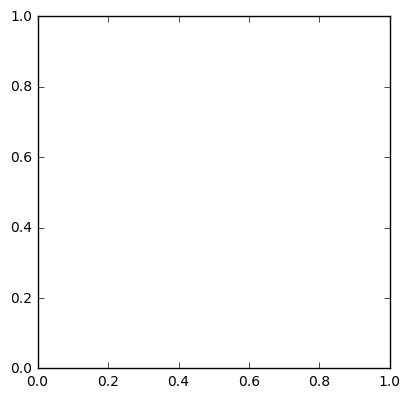

In [174]:
print(fits_mjoactive2)
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_break_mjoactiven, cmap='coolwarm', levels=np.arange(0,0.13,0.001))
plt.plot(np.arange(0,24,2), fits_mjoactive2b[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24,2), fits_mjoactive2b[2,:], color = 'b', linestyle='-', label="Mode 2")
plt.colorbar()
plt.title('MJO active over Australia')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [local]')
plt.ylabel('ETH [km]')

plt.subplot(222)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_break_mjoinactiven, cmap='coolwarm', levels=np.arange(0,0.13,0.001))
plt.plot(np.arange(0,24,2), fits_mjoinactive2b[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24,2), fits_mjoinactive2b[2,:], color = 'b', linestyle='-', label="Mode 2")
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.colorbar()
plt.title('MJO elsewhere')
plt.xlabel('Time in hours [UTC]')
plt.ylabel('ETH [km]')

plt.subplot(223)
plt.plot(np.arange(0,24,2), 2*np.abs(0.5-fits_mjoactive2b[4,:]), label="Mode 1", color='r')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [UTC]')
plt.title('MJO over Australia')
plt.ylabel('Unimodality')

plt.subplot(224)
plt.plot(np.arange(0,24,2), 2*np.abs(0.5-fits_mjoinactive2b[4,:]), label="Mode 1", color='r')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [UTC]')
plt.ylabel('Unimodality')
plt.title('MJO elsewhere')

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.

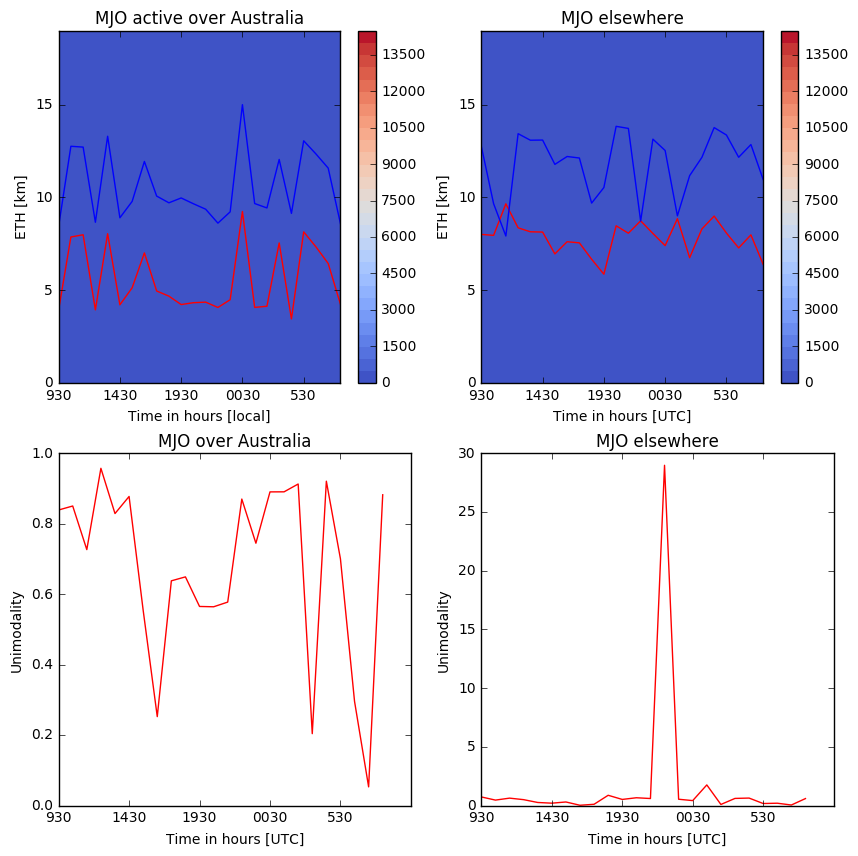

In [41]:
print(hist_monsoon_mjoactiven)
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_monsoon_mjoactiven, cmap='coolwarm', levels=np.arange(0,1.5e4, 500))
plt.plot(np.arange(0,24), fits_mjoactive2[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24), fits_mjoactive2[2,:], color = 'b', linestyle='-', label="Mode 2")
plt.colorbar()
plt.title('MJO active over Australia')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [local]')
plt.ylabel('ETH [km]')

plt.subplot(222)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_monsoon_mjoinactiven, cmap='coolwarm', levels=np.arange(0,1.5e4, 500))
plt.plot(np.arange(0,24), fits_mjoinactive2[0,:], color = 'r', linestyle='-', label="Mode 1")
plt.plot(np.arange(0,24), fits_mjoinactive2[2,:], color = 'b', linestyle='-', label="Mode 2")
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.colorbar()
plt.title('MJO elsewhere')
plt.xlabel('Time in hours [UTC]')
plt.ylabel('ETH [km]')

plt.subplot(223)
plt.plot(np.arange(0,24), 2*np.abs(0.5-fits_mjoactive2[4,:]), label="Mode 1", color='r')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [UTC]')
plt.title('MJO over Australia')
plt.ylabel('Unimodality')

plt.subplot(224)
plt.plot(np.arange(0,24), 2*np.abs(0.5-fits_mjoinactive2[4,:]), label="Mode 1", color='r')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [UTC]')
plt.ylabel('Unimodality')
plt.title('MJO elsewhere')

/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/rjackson/anaconda3/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


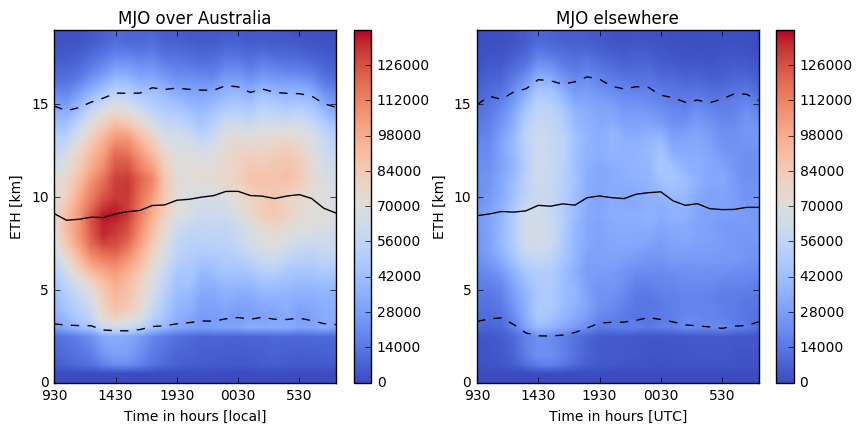

In [97]:
five_active = np.zeros(24)
fifty_active = np.zeros(24)
ninety_five_active = np.zeros(24)
five_inactive = np.zeros(24)
fifty_inactive = np.zeros(24)
ninety_five_inactive = np.zeros(24)

for mjo_index in range(0,24):
    five_active[mjo_index] = calc_percentile_from_hist(hist_total_mjoactive[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty_active[mjo_index] = calc_percentile_from_hist(hist_total_mjoactive[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five_active[mjo_index] = calc_percentile_from_hist(hist_total_mjoactive[:,mjo_index],
                                                       height_bins[:-1]/1e3,
                                                       95)
    five_inactive[mjo_index] = calc_percentile_from_hist(hist_total_mjoinactive[:,mjo_index],
                                                height_bins[:-1]/1e3,
                                                5)
    fifty_inactive[mjo_index] = calc_percentile_from_hist(hist_total_mjoinactive[:,mjo_index],
                                                 height_bins[:-1]/1e3,
                                                 50)
    ninety_five_inactive[mjo_index] = calc_percentile_from_hist(hist_total_mjoinactive[:,mjo_index],
                                                              height_bins[:-1]/1e3,
                                                              95)
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_total_mjoactive, 
            cmap='coolwarm', levels=np.arange(0,140000,200))
plt.plot(np.arange(0,24), five_active, color='k', linestyle='--')
plt.plot(np.arange(0,24), fifty_active, color='k', linestyle='-')
plt.plot(np.arange(0,24), ninety_five_active, color='k', linestyle='--')
plt.colorbar()
plt.title('MJO over Australia')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.xlabel('Time in hours [local]')
plt.ylabel('ETH [km]')

plt.subplot(222)
hours_2d, bins_2d = np.meshgrid(hours, height_bins[:-1]/1e3)
plt.contourf(hours_2d, bins_2d, hist_total_mjoinactive, 
             cmap='coolwarm', levels=np.arange(0,140000,200))
plt.plot(np.arange(0,24), five_inactive, color='k', linestyle='--')
plt.plot(np.arange(0,24), fifty_inactive, color='k', linestyle='-')
plt.plot(np.arange(0,24), ninety_five_inactive, color='k', linestyle='--')
plt.xticks(range(0,24,5), ['930', '1430', '1930', '0030', '530'])
plt.colorbar()
plt.title('MJO elsewhere')
plt.xlabel('Time in hours [UTC]')
plt.ylabel('ETH [km]')

/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in greater
/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


[[ 0. nan nan ... nan nan  0.]
 [ 0. nan nan ... nan nan  0.]
 [ 0. nan nan ... nan nan  0.]
 ...
 [ 0. nan nan ... nan nan  0.]
 [ 0. nan nan ... nan nan  0.]
 [ 0. nan nan ... nan nan  0.]]
(201, 201, 8, 24)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(201, 201, 8, 24)
[[ 0.  0.  0. ... nan nan  0.]
 [ 0.  0.  0. ... nan nan  0.]
 [ 0.  0.  0. ... nan nan  0.]
 ...
 [ 0.  0.  0. ... nan nan  0.]
 [ 0.  0.  0. ... nan nan  0.]
 [ 0.  0.  0. ... nan nan  0.]]
(201, 201, 8, 24)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(201, 201, 8, 24)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(201, 201, 8, 24)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 

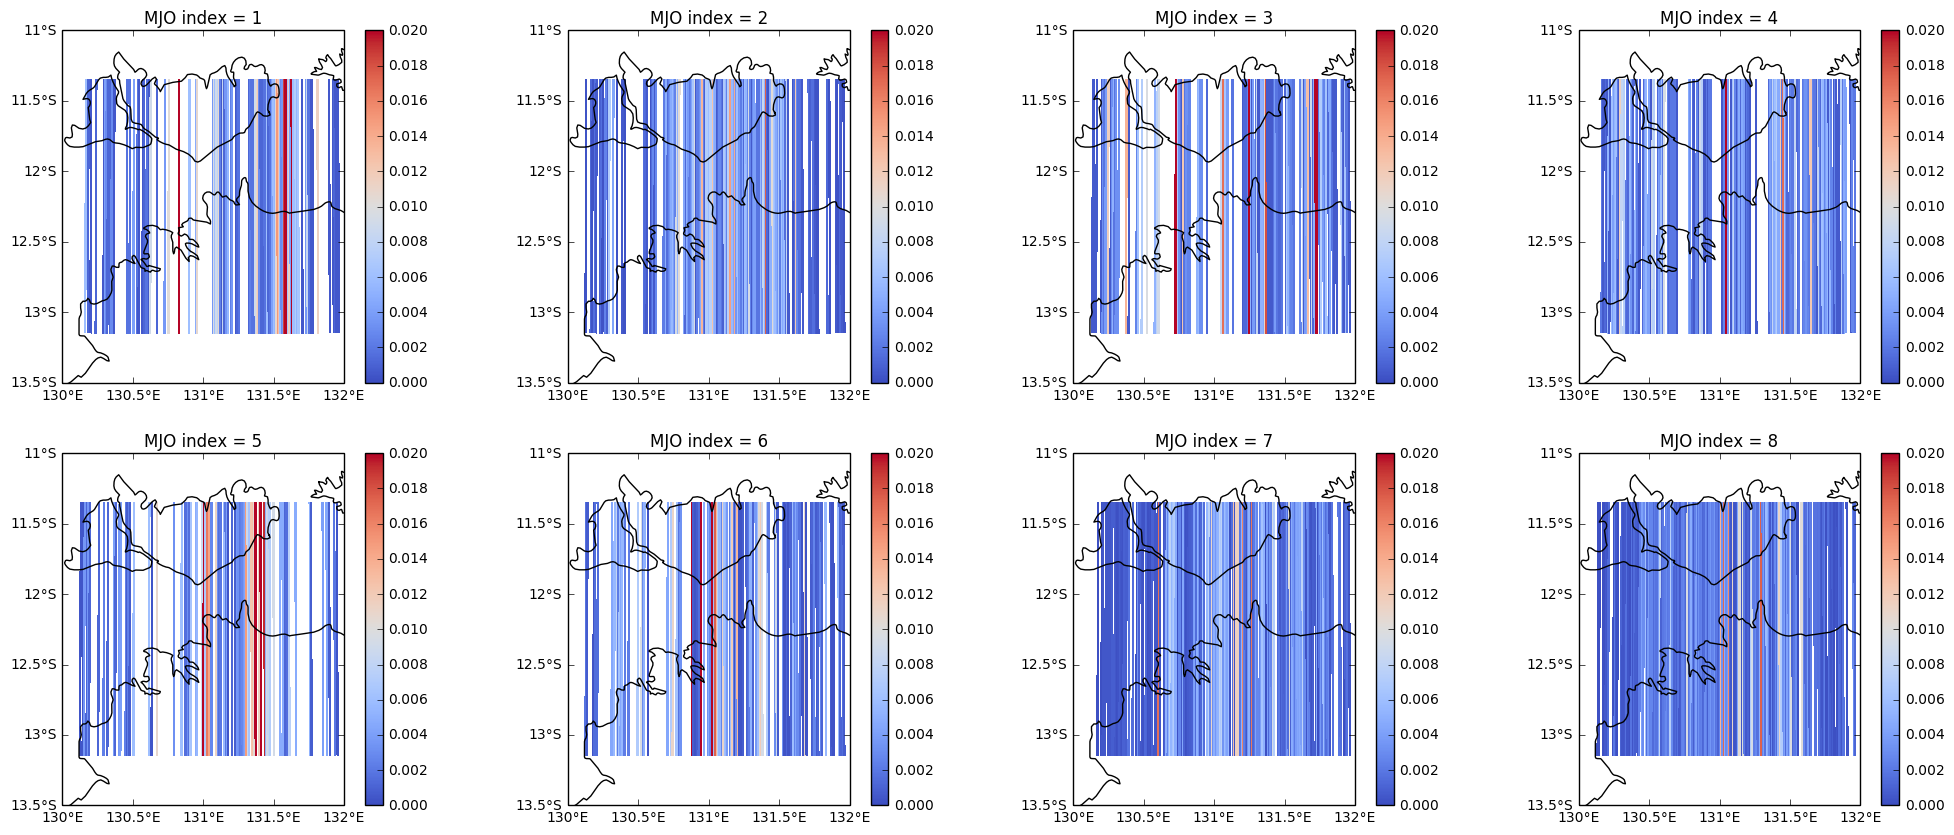

In [217]:
fig, ax = plt.subplots(2, 4, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(25,10))
the_netcdf_list = glob('/home/rjackson/data/new_eth_hists/echo_top_spatial_histograms2_7_20*.cdf')
#del hist_total
for the_netcdf in the_netcdf_list:
    latlon_cdf = Dataset(the_netcdf, mode='r')
    try:
        hist_total = hist_total + latlon_cdf['hist_break'][:]
    except:
        hist_total = latlon_cdf['hist_break'][:]
    print(hist_total[:,:,6,1])
    print(hist_total.shape)
    day_indicies = np.array([0,1,2,3,4,5,6,7,8,9,22,23])
    night_indicies = range(10, 22)
    hist_total = np.nansum(hist_total[:,:,:,day_indicies], axis=3)
    lat = latlon_cdf['lat'][:]
    lon = latlon_cdf['lon'][:]

# Degrade resolution by factor of x
x_factor = 1
lat = lat[::x_factor, ::x_factor]
lon = lon[::x_factor, ::x_factor]
new_hist = np.zeros((lat.shape[0], lat.shape[1],8))
for i in range(0, lat.shape[0]):
    for j in range(0, lat.shape[0]):
        for mjo in range(0,8):
            new_hist[i,j,mjo] = np.sum(hist_total[x_factor*i:x_factor*i+1,x_factor*j:x_factor*j+1,mjo])
        
for mjo_index in range(1,9):
    the_ind = int((mjo_index-1)/4)
    
    ax[the_ind, (mjo_index-1) % 4].coastlines(resolution='10m')
    ax[the_ind, (mjo_index-1) % 4].set_xticks([129, 130, 131, 132, 133], crs=ccrs.PlateCarree())
    ax[the_ind, (mjo_index-1) % 4].set_yticks([-14, -13.5, -13, -12.5, -12,
                                               -11.5, -11,-10.5,], crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax[the_ind, (mjo_index-1) % 4].xaxis.set_major_formatter(lon_formatter)
    ax[the_ind, (mjo_index-1) % 4].yaxis.set_major_formatter(lat_formatter)
    the_hist = new_hist[:,:, mjo_index-1]
    the_hist = np.ma.masked_where(the_hist == 0, the_hist)
    the_plot = ax[the_ind, (mjo_index-1) % 4].pcolormesh(lon, lat, the_hist/np.sum(the_hist)*100, cmap='coolwarm',
                                                         vmin=0, vmax=0.02)
    plt.colorbar(the_plot, ax=ax[the_ind, (mjo_index-1) % 4])
    ax[the_ind, (mjo_index-1) % 4].set_xlim((130.0, 132.0))
    ax[the_ind, (mjo_index-1) % 4].set_ylim((-13.5, -11))
    ax[the_ind, (mjo_index-1) % 4].set_xticks([130.0, 130.5, 131.0, 131.5, 132])
    ax[the_ind, (mjo_index-1) % 4].set_yticks([-13.5, -13.0, -12.5, -12, -11.5, -11.0])
    ax[the_ind, (mjo_index-1) % 4].set_title('MJO index = ' + str(mjo_index))
print(lon.min(), lon.max())
print(lat.min(), lat.max())
print(np.sum(new_hist[:,:,[0,1,2,7]]))
print(np.sum(new_hist[:,:,3:7]))
print(new_hist[:,:,0])

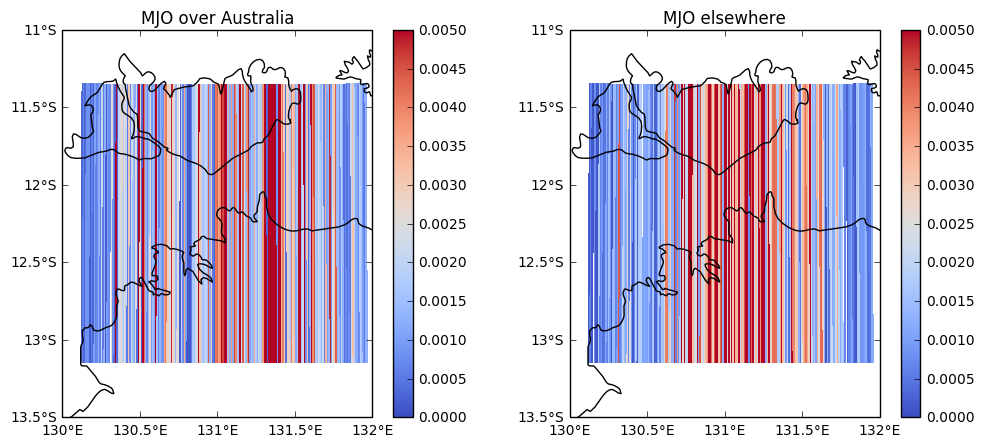

In [212]:
new_hist_4to7 = np.sum(new_hist[:,:,3:7], axis=2)
new_hist_else = np.sum(new_hist[:,:,1:3], axis=2) + new_hist[:,:,7]
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,5))

    
ax[0].coastlines(resolution='10m')
ax[0].set_xticks([129, 130, 131, 132, 133], crs=ccrs.PlateCarree())
ax[0].set_yticks([-14, -13.5, -13, -12.5, -12, -11.5, -11,-10.5,], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[0].xaxis.set_major_formatter(lon_formatter)
ax[0].yaxis.set_major_formatter(lat_formatter)
the_hist = new_hist_4to7
the_hist = np.ma.masked_where(the_hist == 0, the_hist)
the_plot = ax[0].pcolormesh(lon, lat, the_hist/np.sum(the_hist)*100, cmap='coolwarm',
                                                     vmin=0, vmax=0.005)
plt.colorbar(the_plot, ax=ax[0])
ax[0].set_xlim((130.0, 132.0))
ax[0].set_ylim((-13.5, -11))
ax[0].set_xticks([130.0, 130.5, 131.0, 131.5, 132])
ax[0].set_yticks([-13.5, -13.0, -12.5, -12, -11.5, -11.0])
ax[0].set_title('MJO over Australia')

ax[1].coastlines(resolution='10m')
ax[1].set_xticks([129, 130, 131, 132, 133], crs=ccrs.PlateCarree())
ax[1].set_yticks([-14, -13.5, -13, -12.5, -12, -11.5, -11,-10.5,], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax[1].xaxis.set_major_formatter(lon_formatter)
ax[1].yaxis.set_major_formatter(lat_formatter)
the_hist = new_hist_else
the_hist = np.ma.masked_where(the_hist == 0, the_hist)
the_plot = ax[1].pcolormesh(lon, lat, the_hist/np.sum(the_hist)*100, cmap='coolwarm',
                                                     vmin=0, vmax=0.005)
plt.colorbar(the_plot, ax=ax[1])
ax[1].set_xlim((130.0, 132.0))
ax[1].set_ylim((-13.5, -11))
ax[1].set_xticks([130.0, 130.5, 131.0, 131.5, 132])
ax[1].set_yticks([-13.5, -13.0, -12.5, -12, -11.5, -11.0])
ax[1].set_title('MJO elsewhere')

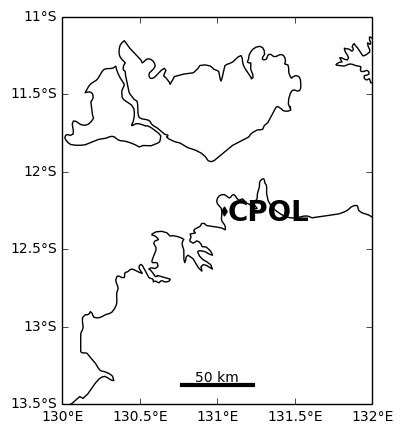

In [78]:
def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')
    
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()), figsize=(12,5))

    
ax.coastlines(resolution='10m')
ax.set_xticks([129, 130, 131, 132, 133], crs=ccrs.PlateCarree())
ax.set_yticks([-14, -13.5, -13, -12.5, -12, -11.5, -11,-10.5,], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
the_hist = new_hist_4to7
the_hist = np.ma.masked_where(the_hist == 0, the_hist)
cpol_latitude = -12.249166
cpol_longitude = 131.04445
plt.text(cpol_longitude+0.02, cpol_latitude-0.07, 'CPOL', fontsize=20, fontweight='bold')
plt.scatter(cpol_longitude, cpol_latitude, marker='d', color='k')
ax.set_xlim((130.0, 132.0))
ax.set_ylim((-13.5, -11))
ax.set_xticks([130.0, 130.5, 131.0, 131.5, 132])
ax.set_yticks([-13.5, -13.0, -12.5, -12, -11.5, -11.0])
scale_bar(ax, length=50)

In [1]:
## Does the way we define ETH matter?

In [42]:
import xarray
from glob import glob

del hist_total
file_list = glob('/home/rjackson/data/ETHdefinitioncomparison*.nc')
for the_file in file_list:
    the_ds = xarray.open_mfdataset(the_file)
    bins_x = the_ds.bins_x.values
    bins_y = the_ds.bins_y.values
    try:
        hist_total = hist_total + the_ds.comparison.values
    except:
        hist_total = the_ds.comparison.values
    the_ds.close()

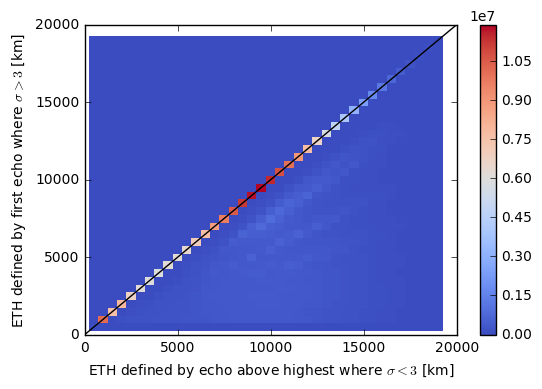

In [52]:
x, y = np.meshgrid(bins_x, bins_y)
plt.pcolormesh(x, y, hist_total, cmap='coolwarm')
plt.plot([0, 20000], [0, 20000], color='k')
plt.colorbar()
plt.ylabel('ETH defined by first echo where $\sigma > 3$ [km]')
plt.xlabel('ETH defined by echo above highest where $\sigma < 3$ [km]')



/home/rjackson/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


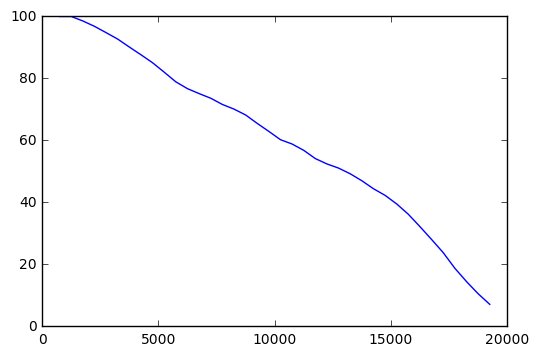

In [53]:
pct_same = np.zeros(len(bins_x))
for i in range(len(bins_x)):
    pct_same[i] = hist_total[i,i]/np.sum(hist_total[:,i], axis=0)*100

plt.plot(bins_x, pct_same)